In [14]:
import os
import zipfile
import urllib
import numpy as np
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2
from src.utils import fetch_eng_data

In [3]:
DOWNLOAD_ROOT = 'https://ti.arc.nasa.gov/'
ENG_PATH = os.path.join('data','nasa_eng')
ENG_URL = DOWNLOAD_ROOT + 'c/6' 

fetch_eng_data(eng_url=ENG_URL, eng_path=ENG_PATH)

In [4]:
new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
df1 = pd.read_csv('data/nasa_eng/train_FD001.txt', sep=' ', names=new_col)
df1.drop(['x1', 'x2'], axis=1, inplace=True)

In [5]:
train_max = df1.groupby('id').cycle.max()
train_max

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

In [6]:
df1['eol'] = df1['id'].apply(lambda x: train_max[x])
df1

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,200
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,200
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,200
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,200


In [7]:
df1['RUL'] = df1['eol'] - df1['cycle']
df1['f30'] = df1['RUL'].apply(lambda x: 1 if x <= 30 else 0)
df1['f10'] = df1['RUL'].apply(lambda x: 1 if x <= 10 else 0)
df1

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,eol,RUL,f30,f10
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,192,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,192,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,192,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,192,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,192,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,0.03,397,2388,100.0,38.49,22.9735,200,4,1,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,0.03,395,2388,100.0,38.30,23.1594,200,3,1,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,0.03,398,2388,100.0,38.44,22.9333,200,2,1,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,0.03,395,2388,100.0,38.29,23.0640,200,1,1,1


In [8]:
win = 5
sensor = {f's{i}': [f'a{i}', f'sd{i}'] for i in range(8,22) }


In [16]:
for s, a in sensor.items():
    for id in train_max.index:
        for window in df1[df1['id'] == id][s].rolling(win):
#             df1[a] = window.mean()
#             print(s, a, id)

In [17]:
df1

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,a17,sd17,a18,sd18,a19,sd19,a20,sd20,a21,sd21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,396.2,396.2,2388.0,2388.0,100.0,100.0,38.378,38.378,23.03648,23.03648


In [10]:
df1.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,eol,RUL,f30,f10
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,216.615724,107.807862,0.150259,0.053318
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,50.028600,68.880990,0.357334,0.224672
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,128.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,185.000000,51.000000,0.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,207.000000,103.000000,0.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,240.000000,155.000000,0.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,362.000000,361.000000,1.000000,1.000000


In [188]:
df1['a13'][20000:20020]

20000   NaN
20001   NaN
20002   NaN
20003   NaN
20004   NaN
20005   NaN
20006   NaN
20007   NaN
20008   NaN
20009   NaN
20010   NaN
20011   NaN
20012   NaN
20013   NaN
20014   NaN
20015   NaN
20016   NaN
20017   NaN
20018   NaN
20019   NaN
Name: a13, dtype: float64

In [86]:
y1 = df1.pop('RUL')
df1.drop('eol', axis=1, inplace=True)

In [87]:
y1

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 20631, dtype: int64

In [105]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 12]

<AxesSubplot:>

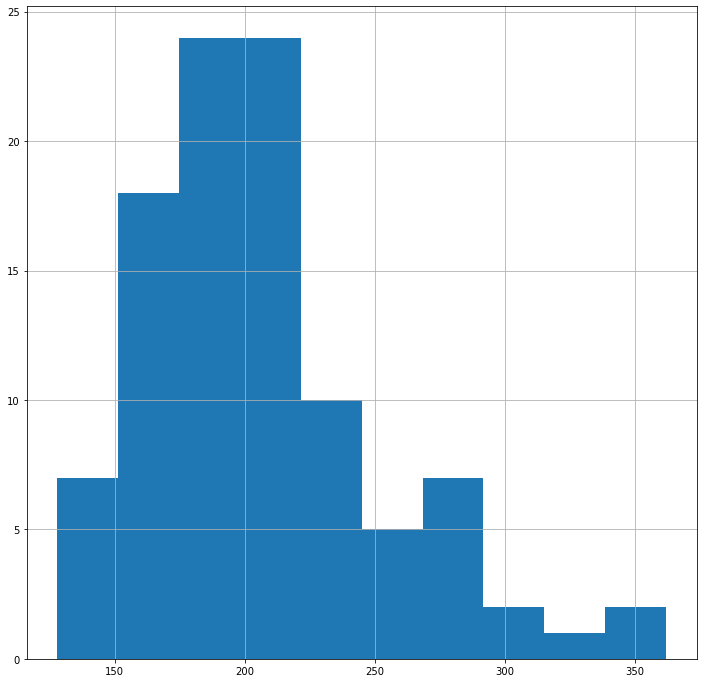

In [107]:
train_max.hist()

In [ ]:
# "s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"

In [138]:
df1[["s1","s2","s3","s4","s5","s6","s7"]].describe()

,s1,s2,s3,s4,s5,s6,s7
count,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000
mean,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711
std,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092
min,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000
25%,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000
50%,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000
75%,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000
max,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000


In [139]:
df1[["s8","s9","s10","s11","s12","s13","s14"]].describe()

,s8,s9,s10,s11,s12,s13,s14
count,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000
mean,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722
std,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176
min,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000
25%,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000
50%,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000
75%,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000
max,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000


In [140]:
df1[["s15","s16","s17","s18","s19","s20","s21"]].describe()

,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [157]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = df1[["s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]]
y = y1
reg = LinearRegression()

reg.fit(X, y)
reg.score(X, y)

In [162]:
from sklearn.linear_model import LogisticRegression

X = df1[["s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]]
y = df1['f10']
reg = LogisticRegression()

reg.fit(X, y)
reg.score(X, y)

/home/arcweld/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9744559158547816

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


clf = RandomForestClassifier()
clf.fit(X,y)